# Игра "5 Букв"
Тинькофф перезапустил игру "5 букв", в которой нужно отгадывать слова. Вам нужно набрать существительное из пяти букв, система покажет какие буквы этого слова есть в загаданном слове, на основе этой информации вы должны отгадать слово за несколько попыток.  
Для призов банк подготовил скидки, кэшбэки и др. Например, за 60 слов можно получить 50%-й кэшбэк в Ozon.
Играем в игруиз приложения Тиньков банка "5 букв".  Правила игры похожи на игру Wordle.
<div>
<img src="game.jpeg" width="200"/>
</div>   
Попробуем придумать какую-нибудь стратегию для выигрыша.

Найдем на просторах гитхаба файл со существительными.  
[https://github.com/Badestrand/russian-dictionary] (Creative Commons Attribution Share Alike 4.0)

In [101]:
# !curl https://github.com/Badestrand/russian-dictionary/raw/master/nouns.csv -o nouns.csv
# !wget -O sample.jpg https://github.com/Badestrand/russian-dictionary/raw/master/nouns.csv

In [102]:
import csv
words = []

with open('nouns.csv', newline='', encoding='utf-8') as csvfile:
    nounsdata = csv.reader(csvfile, delimiter='\t')
    i = 0
    for row in nounsdata:
        words.append(row[0])

words.sort()
(words[:10], len(words))

(['Kалькутта',
  'Kанберра',
  'MP3-плеер',
  'bare',
  'Абакан',
  'Абердин',
  'Абхазия',
  'Австралия',
  'Адыгея',
  'Азазель'],
 26983)

Соберем немного статистики по словам

In [103]:
# %%time
dict={}
alphabet='абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
# соберем статистику по буквам
wrongletters = ''
for w in words:
    for l in w.lower():
        if l in alphabet:
            dict[l] = dict.get(l, 0) + 1
        else:
            if l not in wrongletters:
                wrongletters += l
print(f"символы не в словаре: {wrongletters}")            

символы не в словаре: kmp3-bareo


In [104]:
sorted_tuples = sorted(dict.items(), key=lambda x: x[1],reverse=True) 
sorted_dict = {k: v for k, v in sorted_tuples}
mostusedletters = "".join(list(sorted_dict.keys()))
print(f"Буквы, отсортированные по степени встречаемости: {mostusedletters}")

Буквы, отсортированные по степени встречаемости: аоеинрткслвпдмуьбзгяцчжшыхфйщёюэъ


Для нашей игры выберем из прочитанного списка только те слова, которые:
* состоят из 5 букв
* не содержат символы не из алфавита (дефисы, английские буквы)
* не начинаются с заглавной буквы  
При этом "ё" заменим на "е"

In [105]:
words5l = [w.lower().replace('ё','е') for w in words if (len(w)==5) & (set(w)-set(alphabet)==set()) & (w.lower()[0]==w[0])]
words5l[:5]
len(words5l)

2616

Что насчет дубликатов?

In [106]:
dwords5l = ([w for w in words5l if words5l.count(w)>1])
print(set(dwords5l))

{'кирка', 'станс', 'падеж', 'кегль', 'вафля', 'отзыв', 'сокол', 'броня', 'мошка', 'тупик', 'замок', 'венец', 'телка', 'атлас', 'скала', 'орган', 'рэгги', 'баржа', 'валух', 'повод', 'битум', 'волна', 'басма'}


Почему-то они есть, странно. Удалим дубликаты

In [107]:
words5l=list(set(words5l))
len(words5l)

2593

Снова соберем статистику по буквам

In [108]:
# соберем статистику по буквам
dict={}
wrongletters = ''
for w in words5l:
    for l in w:
        if l in alphabet:
            dict[l] = dict.get(l, 0) + 1
        else:
            if l not in wrongletters:
                wrongletters += l
print(f"символы не в словаре: {wrongletters}")
sorted_tuples = sorted(dict.items(), key=lambda x: x[1],reverse=True)
sorted_dict = {k: v for k, v in sorted_tuples}
mostusedletters = "".join(list(sorted_dict.keys()))
print(f"Буквы, отсортированные по степени встречаемости: {mostusedletters}")

символы не в словаре: 
Буквы, отсортированные по степени встречаемости: аокретилнсупмвбдзгьяшчыхжфйцющэъ


In [109]:
# а теперь посмотрим, на каких местах каждая буква встречается чаще
alphabet='абвгдежзийклмнопрстуфхцчшщъыьэюя' # буква 'ё' по правилам игры заменяется на 'е'
letterplaces={k: [0]*5 for k in alphabet}
for w in words5l:
    for l,i in zip(w,range(5)):        
        letterplaces[l][i] += 1

# letterplaces = {k:[l/sum(letterplaces[k]) for l in letterplaces[k]] for k in letterplaces}  # нормируем места по буквам
# sum([sum(letterplaces[k]) for k in letterplaces]) - len(letterplaces) # =0

Для удобства объявим функцию подсчета "рейтинга" слова. Чем больше в слове часто встречающихся букв, тем лучше. Одинаковые буквы считаются за одну.

In [110]:
def score(w, ignore='', checkplace=True):
    if ignore == '': ignore = '_'*len(w)
    s=0
    for i in range(len(w)):
        if ignore[i] not in alphabet: # вместо буквы находится символ, значит буква учавствует в подсчете
            if not checkplace:
                s += sorted_dict[w[i]]//w.count(w[i])
            else:
                s += letterplaces[w[i]][i]//w.count(w[i])
    return s


(score('попка'), score('попка','_о_ка'), (letterplaces['п'][0] + letterplaces['п'][2]) // 2, sum(letterplaces['п'])//2, sorted_dict['п']//2) # 1477, 163=163, 206=206
 

(1477, 163, 163, 206, 206)

Теперь можно посчитать рейтинг всех слов из 5 букв и найти слова с самыми используемыми буквами

In [111]:
scorelist=[[w, score(w)] for w in words5l]
sorted(scorelist,key=lambda x: x[1],reverse=True)[:10]

[['порка', 1844],
 ['солка', 1798],
 ['полка', 1787],
 ['перка', 1741],
 ['горка', 1728],
 ['сотка', 1727],
 ['парок', 1725],
 ['норка', 1707],
 ['сопка', 1652],
 ['мерка', 1647]]

Начинать игру надо со слова "порка". А если бы местоположение букв не учитывалось, это был бы "коран" или "норка". Ну и ради интереса выведем список 10 самых неудачных для начала игры слов.

In [112]:
sorted(scorelist,key=lambda x: x[1],reverse=True)[-10:]

[['уксус', 247],
 ['хиппи', 245],
 ['овощи', 244],
 ['извив', 242],
 ['рэгги', 233],
 ['уздцы', 225],
 ['дзюдо', 224],
 ['рсфср', 218],
 ['жмыхи', 180],
 ['имидж', 166]]

Хм. "РСФСР" - аббревиатура, надо придумать какой-нибудь фильтр (все буквы согласные? или заглавные?)  
Осталось объявить несколько вспомогательных функций

In [113]:
# проверка слова, как это присходит в игре
def checkword(rightword, testword):
    result=''
    for rl, tl in zip(rightword, testword):
        if tl not in rightword:
            result = result + '-'
        else:
            if tl==rl:
                result = result + '+'
            else:
                result = result + '*'
    return result

print(checkword('крона', 'коран'))

# разбор результата проверки с записью в соответствующие переменные
def scanresults(testword, result, wrongletters='', wrongplaces={}, rightplaces=''):
    if rightplaces=='': rightplaces = '_' * len(testword)
    for r,i in zip(result, range(len(testword))):
        # print (r,i)
        l = testword[i]
        if (r=='-'):
            wrongletters = ''.join(set(wrongletters) | set(l))
        elif (r=='*'):
            wrongplaces[l] = wrongplaces.get(l,[]) + [i]
        else:
            t = list(rightplaces)
            t[i] = l
            rightplaces = ''.join(t)
    return (wrongletters, wrongplaces, rightplaces)

print(scanresults('порка','-+-*-'))
print(scanresults('колея','*+-+-','пра', {'к': [3]}, '_о___'))

+****
('пра', {'к': [3]}, '_о___')
('пляра', {'к': [3, 0]}, '_о_е_')


In [114]:
# вывод списка слов, удовлетворяющих условиям
def predictwords(wrongletters, wrongplaces, rightplaces, wordsarray):
    goodwords = []
    for w in wordsarray:
        badwordflag = False
        
        # 1) в слове должны быть найденные буквы в нужных местах
        for i in range(len(rightplaces)):
            if (rightplaces[i] != '_') & (rightplaces[i] != w[i]):
                badwordflag = True
                break
        if badwordflag: continue
        
        # 2) в слове не должно быть отсутствующих букв
        for l in w:
            if l in wrongletters:
                badwordflag = True
                break
        if badwordflag: continue
        
        # 3) в слове должны быть неправильно расположенные буквы
        # 4) в слове неправильно расположенные буквы не должны быть на неправильных местах
        for l in list(wrongplaces.keys()):
            if l not in w: # неправильно расположенные буквы должны быть в слове (странно, да?)
                badwordflag = True
                break
            else:
                for i in range(len(w)):
                    if (l == w[i]) & (i in wrongplaces[l]): # если место буквы в слове есть в списке "плохих" мест
                        badwordflag = True
                        break
        if badwordflag: continue
        
        # переехало в цикл к условию 3)
        # for l in list(wrongplaces.keys()):
        #     if l not in w:
        #         badwordflag = True
        #         break
        # if badwordflag: continue
        goodwords += [w]
    return goodwords    

Посчитаем, сколько нужно ходов для угадывания каждого слова. Объявим функцию, которая делает одну итерацию игры.

In [115]:
def oneturn(secret, tryword, wrongletters='', wrongplaces={}, rightplaces='', checkplace=True):
    # проверяем слово, разбираем результат
    (wrongletters, wrongplaces, rightplaces) = scanresults(tryword, checkword(secret, tryword), wrongletters, wrongplaces, rightplaces)
    # ищем слова, подходящие по условиям
    nextwords = predictwords(wrongletters, wrongplaces, rightplaces, words5l)
    if(len(nextwords)==1):
        return ('', wrongletters, wrongplaces, rightplaces)
    else:
        # подсчитаем рейтинг найденных слов
        scorelist=[[w, score(w, rightplaces, checkplace)] for w in nextwords]
        newwords=sorted(scorelist,key=lambda x: x[1],reverse=True)
        return(newwords[0][0], wrongletters, wrongplaces, rightplaces) # вернем слово с самым большым рейтингом

Погнали! Сначала посчитаем ходы с учетом местоположения букв в слове (слова с буквами, расопложенными на "популярных" для этой буквы местах оцениваются выше)

In [126]:
%%time
turnswithcheckplace=[]
for w in words5l:
    wrongletters=''; wrongplaces={}; rightplaces=''
    newword='порка'
    counter=0
    while newword != '':
        counter+=1
        if counter>10: break
        (newword, wrongletters, wrongplaces, rightplaces) = oneturn(w, newword, wrongletters, wrongplaces, rightplaces, True)
    turnswithcheckplace += [counter]
#         print(f'Следущее слово: {newword}')

len(turnswithcheckplace)

Wall time: 41.6 s


2593

4,88 с на Intel Core i7 870 @2.93Ggz  
42,2 с на Phenom II X4 960T @3Ggz - какая-то ошибка в установленном питоне, не может быть такая разница

А теперь без учета местоположения букв

In [125]:
%%time
turnswithoutcheckplace=[]
for w in words5l:
    wrongletters=''; wrongplaces={}; rightplaces=''
    newword='порка'
    counter=0
    while newword != '':
        counter+=1
        if counter>10: break
        (newword, wrongletters, wrongplaces, rightplaces) = oneturn(w, newword, wrongletters, wrongplaces, rightplaces, False)
    turnswithoutcheckplace += [counter]
#         print(f'Следущее слово: {newword}')

len(turnswithcheckplace)

Wall time: 43.1 s


2593

4,72 с на Intel Core i7 870 @2.93Ggz  
43,5 с на Phenom II X4 960T @3Ggz

Попробуем использовать pandas, seaborn и построим наглядные гистограммы

<AxesSubplot:xlabel='turns', ylabel='count'>

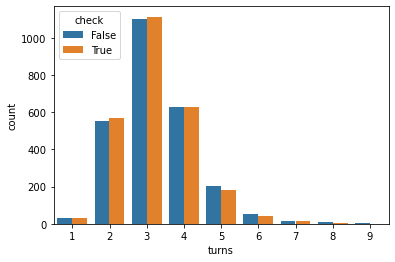

In [118]:
# import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
import seaborn as sns

# соберем датафрейм
df = pd.DataFrame({ 'turns': turnswithoutcheckplace + turnswithcheckplace, 
                    'check': [False]*len(words5l) + [True]*len(words5l)})

# две гистограммы рядом
# _, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
# axes[0].set_title(f"withoutcheckplace (mean={statistics.mean(turnswithoutcheckplace)})")
# axes[1].set_title(f"withcheckplace (mean={statistics.mean(turnswithcheckplace)})")
# sns.histplot(turnswithoutcheckplace, ax=axes[0])
# sns.histplot(turnswithcheckplace, ax=axes[1])

# слишком тонкие прямоугольники
# sns.histplot(x='turns', data=df, hue='check',alpha=0.5, multiple='dodge') 

# красиво, но без подписей
# plt.hist([turnswithoutcheckplace, turnswithcheckplace]);

sns.countplot(x='turns',hue='check',data=df)


Выводы, которые можно сделать из графика:
1) Внезапно, учет местоположения буквы даёт небольшой выигрыш в числе попыток.  
2) Есть такие слова, которые не отгадать за 6 ходов, используя выбранную стратегию. Найдем их

In [119]:
for i in range(len(words5l)):
    if (turnswithoutcheckplace[i]>6) | (turnswithcheckplace[i]>6):
        print(f"{words5l[i]}: {turnswithoutcheckplace[i]} {turnswithcheckplace[i]}")

давка: 7 5
честь: 8 7
тесть: 7 6
дудка: 6 8
гайка: 9 5
жучка: 7 6
жесть: 8 7
бобок: 7 5
шизик: 5 7
байка: 8 6
шавка: 7 5
шашка: 8 8
душка: 7 7
чушка: 7 7
тетка: 7 7
башка: 8 5
щетка: 7 7
мойка: 6 7
дачка: 7 6
чайка: 9 8
дужка: 7 8
бабка: 8 6
чашка: 8 8
божок: 7 5
чуйка: 7 7
качка: 5 7
фишка: 6 7
шишка: 6 7
шайка: 8 8
кашка: 5 7
мошка: 5 7
чижик: 5 7
заика: 5 7
зайка: 5 7


Самое трудное слово для обоих методов расчета рейтинга: "чайка"

In [120]:
(len([[words5l[i],t] for t, i in zip(turnswithoutcheckplace,range(len(turnswithoutcheckplace))) if t > 6]),
len([[words5l[i],t] for t, i in zip(turnswithcheckplace,range(len(turnswithoutcheckplace))) if t > 6]))

(23, 23)

Количество слов, которые не отгадываются за 6 ходов слов, одинаковое для обоих способов расчета рейтинга.  
Судя по гистограмме, есть слова, которые угадываются на второй ход. Посмотрим на них.

In [121]:
print([words5l[i] for t, i in zip(turnswithcheckplace,range(len(turnswithoutcheckplace))) if t == 1])

['капер', 'парик', 'право', 'копра', 'укроп', 'нерпа', 'показ', 'паром', 'крепь', 'капор', 'серко', 'порча', 'комар', 'толпа', 'пункт', 'бурки', 'порок', 'копна', 'порка', 'покер', 'осока', 'копер', 'репка', 'кобра', 'коран', 'пирог', 'пикша', 'крупа', 'пивко', 'парок', 'скрап']


Посмотрим, сколько ходов нужно сделать, что бы угадать слово "чайка"

In [122]:
tryword = 'порка'
secret = 'чайка'
wrongletters=''; wrongplaces={}; rightplaces=''
i = 0
while i < 10:
    i += 1
    checkresult = checkword(secret, tryword)
    (wrongletters, wrongplaces, rightplaces) = scanresults(tryword, checkresult, wrongletters, wrongplaces, rightplaces)
    nextwords = predictwords(wrongletters, wrongplaces, rightplaces, words5l)
    print( (tryword, checkresult,rightplaces,len(nextwords)) )
    if(len(nextwords)==1):
        print(nextwords)
        break
    else:
        scorelist=[[w, score(w, rightplaces)] for w in nextwords]
        newwords=sorted(scorelist,key=lambda x: x[1],reverse=True)
        tryword=newwords[0][0]


('порка', '---++', '___ка', 138)
('белка', '---++', '___ка', 74)
('самка', '-+-++', '_а_ка', 22)
('ватка', '-+-++', '_а_ка', 14)
('ганка', '-+-++', '_а_ка', 10)
('кадка', '*+-++', '_а_ка', 6)
('заика', '-+-++', '_а_ка', 4)
('шайка', '-++++', '_айка', 1)
['чайка']


А теперь забубеним мега-функцию, которая на основании предыдущих попыток предлагает новое слово

In [135]:
def predictnextword(attempts):
    wrongletters = ''
    wrongplaces = {}
    rightplaces = ''

    # разберем попытки   
    for tryword,result in attempts:
        wrongletters, wrongplaces, rightplaces = scanresults(tryword, result, wrongletters, wrongplaces, rightplaces)

    # print((wrongletters, wrongplaces, rightplaces))
    nextwords = predictwords(wrongletters, wrongplaces, rightplaces, words5l)
    scorelist=[[w, score(w, rightplaces)] for w in nextwords]
    newwords=sorted(scorelist,key=lambda x: x[1],reverse=True)
    return f"{min(10,len(newwords))} из {len(newwords)}:", newwords[:10]

In [139]:
predictnextword([['порка','---++'],['белка','---++'],['самка','-+-++'],['ватка','-+-++'],['ганка','-+-++'],['кадка','*+-++']])   

('6 из 6:',
 [['заика', 180],
  ['зайка', 129],
  ['шайка', 111],
  ['чашка', 101],
  ['чайка', 86],
  ['шашка', 62]])